In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

import plotly.express as px

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---

Stefano's estimated T90s by energy,

- 8 keV: 267 sec
- 200 keV: 284 sec
- 1 MeV: 252 sec
- 40 MeV: 183 sec
- 200 GeV: 36.7 sec

So we look for sources which glow for 250+s in the GBM and 35-180s in the LAT

In [2]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]
    targets['gcn_name'] = targets['gcn_name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]

    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']
    targets['hardness'] = targets['like_lat_fluence']/targets['like_gbm_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    
    targets['hardness_error'] = propagate_error(targets['like_lat_fluence'],
                                                targets['like_gbm_fluence'],
                                                targets['like_lat_fluence_error'],
                                                targets['like_gbm_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_t90_difference'] = targets['gbm_cat_t90'] - targets['lle_t90']
    return targets

In [3]:
# Load the FullCatalog.fits dataset
dat = Table.read('FullCatalog.fits')
all_candidates = dat.to_pandas()

# Cleaning data
all_candidates = clean_data(all_candidates)
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

#all_candidates.info()

all_candidates.T.tail(8).T.describe()

,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
count,223.0,223.0,157.0,157.0,157.0,157.0,231.0,231.0
unique,159.0,159.0,143.0,143.0,143.0,143.0,222.0,226.0
top,0.0,inf,0.0,0.0,0.0,0.0,0.0,60.0
freq,58.0,58.0,15.0,15.0,15.0,15.0,8.0,3.0


Hardness > 1
GBM T90 in []

In [45]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

unassoc_hard_candidates = all_candidates.query('redshift == 0 & hardness > 1')
unassoc_hard_candidates['hardness_upper'] = unassoc_hard_candidates['hardness'] + unassoc_hard_candidates['hardness_error']

In [80]:

print('Total unassociated sources: %s'%unassoc_hard_candidates.shape[0])

print( 'N. sources with lle_t90 = 0.: %s'%unassoc_hard_candidates.query('lle_t90==0').shape[0])

inf = np.infty
print( 'N. sources with infinite hardness: %s'% unassoc_hard_candidates.query('hardness == @inf').shape[0])
print( 'N. sources that are lle_t90 = 0. AND have infinite hardness: %s'%unassoc_hard_candidates.query('lle_t90==0 & hardness==@inf').shape[0])


print('N. sources with GBM t90=0.: %s'%unassoc_hard_candidates.query('gbm_cat_t90 == 0').shape[0])

Total unassociated sources: 138
N. sources with lle_t90 = 0.: 77
N. sources with infinite hardness: 43
N. sources that are lle_t90 = 0. AND have infinite hardness: 37
N. sources with GBM t90=0.: 0


There are a bunch of quirks in this dataset:
- There are 'infinite' hardnesses. This is because the GBM fluence was registered as 0.
- A bunch of the sources are lle_t90 = 0. This accounts for 

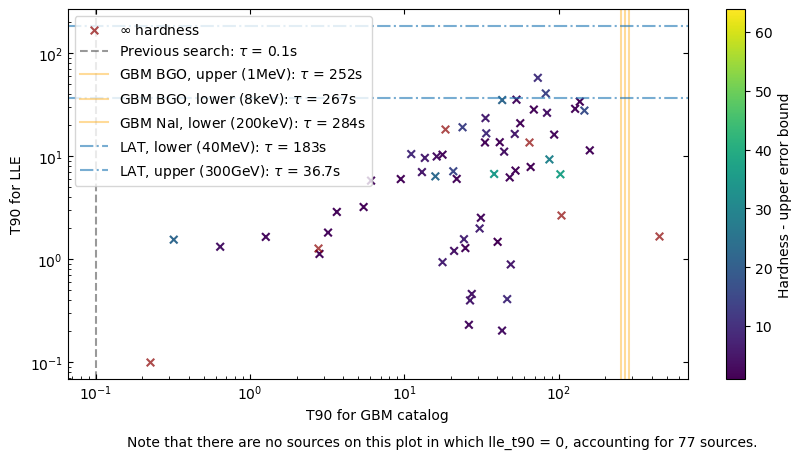

In [105]:
fig, ax = plt.subplots()

# Scatter plot all objects.
sx = ax.scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['lle_t90'], marker = 'x', c=(unassoc_hard_candidates['hardness_upper']), s=30, cmap='viridis')
fig.colorbar(sx, ax=ax, label = 'Hardness - upper error bound')


# Include the objects with 'infinite' hardness.
inf = np.infty
_ = unassoc_hard_candidates.query('hardness == @inf')
ax.scatter(_['gbm_cat_t90'], _['lle_t90'], color='darkred', marker='x', s=30, label = f'$\infty$ hardness', alpha=.7)

# Previous estimation
ax.axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax.axvline(252, linestyle='-',  label = r'GBM BGO, upper (1MeV): $\tau$ = 252s', color='orange', alpha=.4)
ax.axvline(267, linestyle='-',  label = r'GBM BGO, lower (8keV): $\tau$ = 267s', color='orange', alpha=.4)
ax.axvline(284, linestyle='-',  label = r'GBM NaI, lower (200keV): $\tau$ = 284s', color='orange', alpha=.4)

# LAT energies
ax.axhline(183, linestyle='-.',  label = r'LAT, lower (40MeV): $\tau$ = 183s', alpha=.6)
ax.axhline(36.7, linestyle='-.',  label = r'LAT, upper (300GeV): $\tau$ = 36.7s', alpha=.6)


# Labels
ax.set_ylabel('T90 for LLE')
ax.set_xlabel('T90 for GBM catalog')

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# x, yticks on inside & on top/right
ax.tick_params(axis="x", bottom=True, top=True)
ax.tick_params(axis="y", left=True, right=True)
ax.tick_params(axis="both", which="both", direction="in")


plt.figtext(0.5, -0.03, 'Note that there are no sources on this plot in which lle_t90 = 0, accounting for 77 sources.', wrap=True, horizontalalignment='center', fontsize=10)

fig.set_figwidth(20)
fig.set_figwidth(10)
ax.legend()

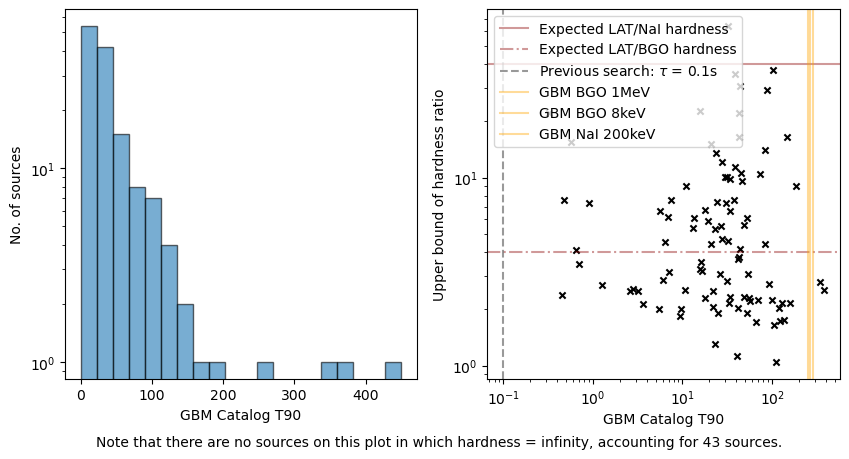

In [112]:
# In that spirit, let's focus mainly on the GBM T90.


fig, ax = plt.subplots(1,2)

ax[0].hist(unassoc_hard_candidates['gbm_cat_t90'], alpha = 0.6, edgecolor='black', bins=20)
ax[0].set_yscale('log')
ax[0].set_xlabel('GBM Catalog T90')
ax[0].set_ylabel('No. of sources')

ax[1].scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['hardness_upper'], marker='x', color='black', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('GBM Catalog T90')
ax[1].set_ylabel('Upper bound of hardness ratio')

# Estimated hardness
ax[1].axhline(40, linestyle='-', color='darkred', alpha=.4, label='Expected LAT/NaI hardness')
ax[1].axhline(4, linestyle='-.', color='darkred', alpha=.4, label='Expected LAT/BGO hardness')

# Previous estimation
ax[1].axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax[1].axvline(252, linestyle='-',  label = r'GBM BGO 1MeV', color='orange', alpha=.4)
ax[1].axvline(267, linestyle='-',  label = r'GBM BGO 8keV', color='orange', alpha=.4)
ax[1].axvline(284, linestyle='-',  label = r'GBM NaI 200keV', color='orange', alpha=.4)

ax[1].legend()

plt.figtext(0.5, -0.03, 'Note that there are no sources on this plot in which hardness = infinity, accounting for 43 sources.\nHardness is an estimation from Stefano\'s plot.',
 wrap=True, horizontalalignment='center', fontsize=10)

fig.set_figwidth(20)
fig.set_figwidth(10)

--------

In [4]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

px.scatter(selected_candidates, x='gbm_cat_t90', y='lle_t90', color='hardness')

In [7]:
all_candidates['log_hardness'] = np.log(all_candidates['hardness'])
fig = px.scatter(all_candidates.query('redshift == 0 & hardness > 1'), x='gbm_cat_t90', y='lle_t90', color='log_hardness', log_y=True, log_x=True)
fig

In [28]:
str = ''
for name in selected_candidates['name']:
    str+='%s OR '%name

str

'GRB080916009 OR GRB150523396 OR GRB170424425 OR GRB170405777 OR GRB180720598 OR GRB170214649 OR GRB130504978 OR GRB160625945 OR GRB120624933 OR GRB120420858 OR GRB090323002 OR GRB130427324 OR GRB130828306 OR GRB160821857 OR GRB130907904 OR GRB110903111 OR GRB081203581 OR '